# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-28 09:00:00+09:00,53023.878906,53105.019531,52853.648438,52939.460938,0,0.0,0.0
2026-01-28 09:15:00+09:00,52923.109375,52966.988281,52857.269531,52908.511719,0,0.0,0.0
2026-01-28 09:30:00+09:00,52912.179688,52922.570312,52845.988281,52856.328125,0,0.0,0.0
2026-01-28 09:45:00+09:00,52857.710938,53007.628906,52788.101562,52990.500000,0,0.0,0.0
2026-01-28 10:00:00+09:00,52994.839844,53096.179688,52953.750000,53078.238281,0,0.0,0.0
2026-01-28 10:15:00+09:00,53082.050781,53135.898438,53044.570312,53102.578125,0,0.0,0.0
2026-01-28 10:30:00+09:00,53099.351562,53106.429688,53014.781250,53024.820312,0,0.0,0.0
2026-01-28 10:45:00+09:00,53025.941406,53027.390625,52919.761719,52982.101562,0,0.0,0.0
2026-01-28 11:00:00+09:00,52984.761719,53150.679688,52973.269531,53068.421875,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-01-28 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-01-28 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-01-21 00:00:00+09:00    52774.640625
2026-01-22 00:00:00+09:00    53688.890625
2026-01-23 00:00:00+09:00    53846.871094
2026-01-26 00:00:00+09:00    52885.250000
2026-01-27 00:00:00+09:00    53333.539062
2026-01-28 00:00:00+09:00    53300.398438
Name: Close, dtype: float64


Date
2026-01-27 00:00:00+09:00    53333.539062
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-309.66


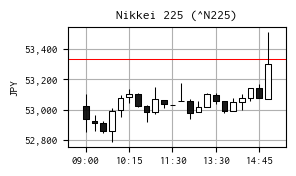

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-27 09:00:00+09:00,154.386002,154.449997,154.113998,154.136002,0,0.0,0.0
2026-01-27 09:15:00+09:00,154.136002,154.242996,154.117996,154.242996,0,0.0,0.0
2026-01-27 09:30:00+09:00,154.240005,154.242004,154.113998,154.205994,0,0.0,0.0
2026-01-27 09:45:00+09:00,154.203003,154.317993,154.139999,154.287994,0,0.0,0.0
2026-01-27 10:00:00+09:00,154.287994,154.389999,154.244995,154.306000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-28 14:15:00+09:00,152.608002,152.619995,152.503006,152.539001,0,0.0,0.0
2026-01-28 14:30:00+09:00,152.528000,152.621002,152.466995,152.578995,0,0.0,0.0
2026-01-28 14:45:00+09:00,152.582001,152.735992,152.569000,152.626999,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-01-28 09:00:00+09:00,347.330887,347.862395,346.215798,346.777910
2026-01-28 09:15:00+09:00,346.677591,346.965024,346.246301,346.581968
2026-01-28 09:30:00+09:00,346.767272,346.835368,346.333478,346.401241
2026-01-28 09:45:00+09:00,346.314997,347.297235,345.858928,347.185009
2026-01-28 10:00:00+09:00,346.840759,347.504008,346.571834,347.386585
2026-01-28 10:15:00+09:00,347.179759,347.531946,346.934621,347.314017
2026-01-28 10:30:00+09:00,347.306536,347.352832,346.753387,346.819050
2026-01-28 10:45:00+09:00,346.604232,346.613704,345.910188,346.317672
2026-01-28 11:00:00+09:00,346.208333,347.292460,346.133242,346.754978


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-01-27 15:15:00+09:00


np.float64(154.58999633789062)

前日終値（ドル換算） 344.9999374210978


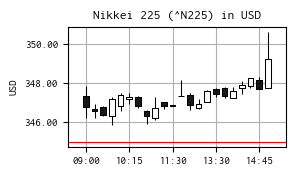

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()